In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import atan2, degrees
import copy
from cycler import cycler

golden_mean = (np.sqrt(5.0)-1.0)/2.0

subplotlabelfont = {#'family': 'Helvetica',
        'fontweight': 'bold',
        'fontsize': 9
        }

def format_axes(axes, position=(-.1, 1.02)):
    for i, ax in enumerate(axes, start=97):
        ax.text(*position, chr(i), fontdict=subplotlabelfont, weight='bold',
                transform=ax.transAxes)

def figsize(scale, aspect_ratio = golden_mean):
    fig_width_pt = 246.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch

    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*aspect_ratio              # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

rcparams = {                      # setup matplotlib to use latex for output
    #"text.usetex": False,                # use LaTeX to write all text
    #"font.family": "sans-serif",
    #"font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    #"font.sans-serif": ["Helvetica"],
    #"font.monospace": [],
    "axes.labelsize": 12,               # LaTeX default is 10pt font.
    "axes.linewidth": .5,
    'lines.linewidth': .5,
    "xtick.major.width": .5,
    "ytick.major.width": .5,
    "lines.markersize":.05,
    "font.size": 9,
    "legend.fontsize": .3,               # Make the legend/label fonts a little smaller
    "axes.spines.top": True,
    "axes.spines.right": True,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize(1),     # default fig size of 0.9 textwidth
#    "mathtext.fontset" : "custom",
#     "mathtext.rm" :  "Helvetica",
#     "mathtext.it" :  "Helvetica:italic",
#     "mathtext.bf" :  "Helvetica:bold",
#     "mathtext.sf" :  "Helvetica",
#     "mathtext.tt" :  "DejaVu Sans",
#     "mathtext.cal" : "DejaVu Sans:italic",
    }

mpl.rcParams.update(rcparams)

Grad = ['#03fc28','#b503fc','#ff0000','#f5b942','#00ffaf','#FFAEBC','#B4F8C8','#C70039','#FFA500','#ffe800','#ff0078', '#00ffba','#1f52fe','#ff9600']
            
mpl.rcParams['axes.prop_cycle'] =cycler(color=Grad)
dt=1e-3
steps=int(2e5)
x=np.array(list(range(0,steps)))*dt
a=1
a2=.4

plt.style.use(['seaborn-whitegrid'])#(['Solarize_Light2'])


In [2]:
import pandas as pd
Data_01_agent=pd.read_json('./dati2/data_meanbootm1000_agent1_N1000_t200000.json')
Data_01_null=pd.read_json('./dati2/data_meanbootm1000_benchnull_1_N1000_t200000.json')
Data_01_noise=pd.read_json('./dati2/data_meanbootm1000_benchnoise_1_N1000_t200000.json')
Data_01_dumb=pd.read_json('./dati2/data_meanbootm1000_benchdumb_1_N1000_t200000.json')
Data_05_agent=pd.read_json('./dati2/data_meanbootm1000_agent5_N1000_t200000.json')
Data_05_null=pd.read_json('./dati2/data_meanbootm1000_benchnull_5_N1000_t200000.json')
Data_05_noise=pd.read_json('./dati2/data_meanbootm1000_benchnoise_5_N1000_t200000.json')
Data_05_dumb=pd.read_json('./dati2/data_meanbootm1000_benchdumb_5_N1000_t200000.json')
Data_09_agent=pd.read_json('./dati2/data_meanbootm1000_agent9_N1000_t200000.json')
Data_09_null=pd.read_json('./dati2/data_meanbootm1000_benchnull_9_N1000_t200000.json')
Data_09_noise=pd.read_json('./dati2/data_meanbootm1000_benchnoise_9_N1000_t200000.json')
Data_09_dumb=pd.read_json('./dati2/data_meanbootm1000_benchdumb_9_N1000_t200000.json')

In [14]:
def bootstrap_int(data):#input must be the series turned to array, for example data=np.array(Data_09_dumb['Fisher_Cl'].to_list())
    d=len(data[0])
    steps=len(data)
    std=[]
    for i in range(0,steps):
        sample=np.random.choice(data[i],size=(1000,d))
        means=np.mean(sample,axis=1)
        conf_int=np.percentile(means,[2.5,97.5])
        std.append(0.5*(conf_int[1]-conf_int[0]))
    std=np.array(std)
    return std

def mean(series):#calculates mean, input is a series, for example Data_09_dumb['Fisher_Cl']
    tmp=np.zeros((len(series)))
    for i in range(0,len(series)):
        tmp[i]=np.mean((np.array(series[i])))
    return tmp

def absmean(series):#calculates mean of abs values, input is a series, for example Data_09_dumb['Fisher_Cl']
    abs=np.zeros((len(series)))
    for i in range(0,len(series)):
        abs[i]=np.mean(np.abs(np.array(series[i])))
    return abs

def get_sc_mean(data): #calculates sc_mean
    sc_ag=[]
    min_ag=[]
    for i in range(0,len(data['sc_00'])):
        sc_00=np.mean(np.array(data['sc_00'][i]))
        sc_01=np.mean(np.array(data['sc_01'][i]))
        sc_10=np.mean(np.array(data['sc_10'][i]))
        sc_11=np.mean(np.array(data['sc_11'][i]))
        sc_ag.append(np.array([[sc_00,sc_01],[sc_10,sc_11]]))
    return sc_ag

def get_perpend_squeeze(data,b): #given the dataset and a decibel treshold b,  
    lim=10**(b/(-10))            #calculates the percentage of trajectories with perpendicular squeezing lower than b
    sc_00=np.array(data['sc_00'].to_list())
    sc_01=np.array(data['sc_01'].to_list())
    sc_10=np.array(data['sc_10'].to_list())
    sc_11=np.array(data['sc_11'].to_list())
    #dr_0,dr_1=get_dr(data)
    r_0=np.array(data['r_0'].to_list())
    r_1=np.array(data['r_1'].to_list())
    d=len(r_0[0,:])
    squeez_perp=[]
    
    for i in range(0,200):
        tempo=[]
        for j in range(0,1000):
            sc=np.array([[sc_00[i,j],sc_01[i,j]],[sc_10[i,j],sc_11[i,j]]])
            r=np.array([r_0[i,j],r_1[i,j]])
            phi=np.arctan(r[1]/(r[0]))
            #print(phi)
            R=np.array([[np.cos(-phi),-np.sin(-phi)],[np.sin(-phi),np.cos(-phi)]])
            tmp=R@sc@(R.T)
            
            tempo.append(tmp[1,1])
            #print(np.mean(tempo))
        tempo=np.array(tempo)
        squeez_perp.append(np.count_nonzero((tempo < lim))/tempo.size)
    
    return np.array(squeez_perp)

def get_absr(data):
    qabs=absmean(data['r_0'])
    pabs=absmean(data['r_1'])
    return (qabs**2+pabs**2)**0.5

x=Data_01_dumb['t']

def ot(arg,a=True,time=x):
    if a==True:
        tmp=np.divide(arg,time)
    else:
        tmp=arg
    return tmp

In [4]:
#qui si salvano le medie e gli intervalli di confidenza delle fisher classiche per ogni dataset
#se si vuole usare le fisher/tempo selezionare ontime=True, altrimenti False

ontime=True
fishercl01dumb=ot(mean(Data_01_dumb['Fisher_Cl']),a=ontime)
fishercl01dumb_int=ot(bootstrap_int(np.array(Data_01_dumb['Fisher_Cl'].to_list())),a=ontime)
fishercl01agent=ot(mean(Data_01_agent['Fisher_Cl']),a=ontime)
fishercl01agent_int=ot(bootstrap_int(np.array(Data_01_agent['Fisher_Cl'].to_list())),a=ontime)
fishercl01null=ot(mean(Data_01_null['Fisher_Cl']),a=ontime)
fishercl01null_int=ot(bootstrap_int(np.array(Data_01_null['Fisher_Cl'].to_list())),a=ontime)

fishercl05dumb=ot(mean(Data_05_dumb['Fisher_Cl']),a=ontime)
fishercl05dumb_int=ot(bootstrap_int(np.array(Data_05_dumb['Fisher_Cl'].to_list())),a=ontime)
fishercl05agent=ot(mean(Data_05_agent['Fisher_Cl']),a=ontime)
fishercl05agent_int=ot(bootstrap_int(np.array(Data_05_agent['Fisher_Cl'].to_list())),a=ontime)
fishercl05null=ot(mean(Data_05_null['Fisher_Cl']),a=ontime)
fishercl05null_int=ot(bootstrap_int(np.array(Data_05_null['Fisher_Cl'].to_list())),a=ontime)

fishercl09dumb=ot(mean(Data_09_dumb['Fisher_Cl']),a=ontime)
fishercl09dumb_int=ot(bootstrap_int(np.array(Data_09_dumb['Fisher_Cl'].to_list())),a=ontime)
fishercl09agent=ot(mean(Data_09_agent['Fisher_Cl']),a=ontime)
fishercl09agent_int=ot(bootstrap_int(np.array(Data_09_agent['Fisher_Cl'].to_list())),a=ontime)
fishercl09null=ot(mean(Data_09_null['Fisher_Cl']),a=ontime)
fishercl09null_int=ot(bootstrap_int(np.array(Data_09_null['Fisher_Cl'].to_list())),a=ontime)


In [5]:
#qui si salvano le medie e gli intervalli di confidenza delle fisher quantistiche per ogni dataset

#se si vuole usare le fisher/tempo selezionare ontime=True, altrimenti False

ontime=True
fisherq01dumb=ot(mean(Data_01_dumb['Fisher_Quantum']),a=ontime)
fisherq01dumb_int=ot(bootstrap_int(np.array(Data_01_dumb['Fisher_Quantum'].to_list())),a=ontime)
fisherq01agent=ot(mean(Data_01_agent['Fisher_Quantum']),a=ontime)
fisherq01agent_int=ot(bootstrap_int(np.array(Data_01_agent['Fisher_Quantum'].to_list())),a=ontime)
fisherq01null=ot(mean(Data_01_null['Fisher_Quantum']),a=ontime)
fisherq01null_int=ot(bootstrap_int(np.array(Data_01_null['Fisher_Quantum'].to_list())),a=ontime)

fisherq05dumb=ot(mean(Data_05_dumb['Fisher_Quantum']),a=ontime)
fisherq05dumb_int=ot(bootstrap_int(np.array(Data_05_dumb['Fisher_Quantum'].to_list())),a=ontime)
fisherq05agent=ot(mean(Data_05_agent['Fisher_Quantum']),a=ontime)
fisherq05agent_int=ot(bootstrap_int(np.array(Data_05_agent['Fisher_Quantum'].to_list())),a=ontime)
fisherq05null=ot(mean(Data_05_null['Fisher_Quantum']),a=ontime)
fisherq05null_int=ot(bootstrap_int(np.array(Data_05_null['Fisher_Quantum'].to_list())),a=ontime)

fisherq09dumb=ot(mean(Data_09_dumb['Fisher_Quantum']),a=ontime)
fisherq09dumb_int=ot(bootstrap_int(np.array(Data_09_dumb['Fisher_Quantum'].to_list())),a=ontime)
fisherq09agent=ot(mean(Data_09_agent['Fisher_Quantum']),a=ontime)
fisherq09agent_int=ot(bootstrap_int(np.array(Data_09_agent['Fisher_Quantum'].to_list())),a=ontime)
fisherq09null=ot(mean(Data_09_null['Fisher_Quantum']),a=ontime)
fisherq09null_int=ot(bootstrap_int(np.array(Data_09_null['Fisher_Quantum'].to_list())),a=ontime)


In [9]:
#qui si salvano le medie e gli intervalli di confidenza delle fisher quantistiche per ogni dataset

#se si vuole usare le fisher/tempo selezionare ontime=True, altrimenti False

ontime=True
fishertot01dumb=ot(mean(Data_01_dumb['Fisher_Quantum']+Data_01_dumb['Fisher_Cl']),a=ontime)
fishertot01dumb_int=ot(bootstrap_int(np.array((Data_01_dumb['Fisher_Quantum']+Data_01_dumb['Fisher_Cl']).to_list())),a=ontime)
fishertot01agent=ot(mean(Data_01_agent['Fisher_Quantum']+Data_01_agent['Fisher_Cl']),a=ontime)
fishertot01agent_int=ot(bootstrap_int(np.array((Data_01_agent['Fisher_Quantum']+Data_01_agent['Fisher_Cl']).to_list())),a=ontime)
fishertot01null=ot(mean(Data_01_null['Fisher_Quantum']+Data_01_null['Fisher_Cl']),a=ontime)
fishertot01null_int=ot(bootstrap_int(np.array((Data_01_null['Fisher_Quantum']+Data_01_null['Fisher_Cl']).to_list())),a=ontime)

fishertot05dumb=ot(mean(Data_05_dumb['Fisher_Quantum']+Data_05_dumb['Fisher_Cl']),a=ontime)
fishertot05dumb_int=ot(bootstrap_int(np.array((Data_05_dumb['Fisher_Quantum']+Data_05_dumb['Fisher_Cl']).to_list())),a=ontime)
fishertot05agent=ot(mean(Data_05_agent['Fisher_Quantum']+Data_05_agent['Fisher_Cl']),a=ontime)
fishertot05agent_int=ot(bootstrap_int(np.array((Data_05_agent['Fisher_Quantum']+Data_05_agent['Fisher_Cl']).to_list())),a=ontime)
fishertot05null=ot(mean(Data_05_null['Fisher_Quantum']+Data_05_null['Fisher_Cl']),a=ontime)
fishertot05null_int=ot(bootstrap_int(np.array((Data_05_null['Fisher_Quantum']+Data_05_null['Fisher_Cl']).to_list())),a=ontime)

fishertot09dumb=ot(mean(Data_09_dumb['Fisher_Quantum']+Data_09_dumb['Fisher_Cl']),a=ontime)
fishertot09dumb_int=ot(bootstrap_int(np.array((Data_09_dumb['Fisher_Quantum']+Data_09_dumb['Fisher_Cl']).to_list())),a=ontime)
fishertot09agent=ot(mean(Data_09_agent['Fisher_Quantum']+Data_09_agent['Fisher_Cl']),a=ontime)
fishertot09agent_int=ot(bootstrap_int(np.array((Data_09_agent['Fisher_Quantum']+Data_09_agent['Fisher_Cl']).to_list())),a=ontime)
fishertot09null=ot(mean(Data_09_null['Fisher_Quantum']+Data_09_null['Fisher_Cl']),a=ontime)
fishertot09null_int=ot(bootstrap_int(np.array((Data_09_null['Fisher_Quantum']+Data_09_null['Fisher_Cl']).to_list())),a=ontime)


<Figure size 490.162x302.937 with 0 Axes>

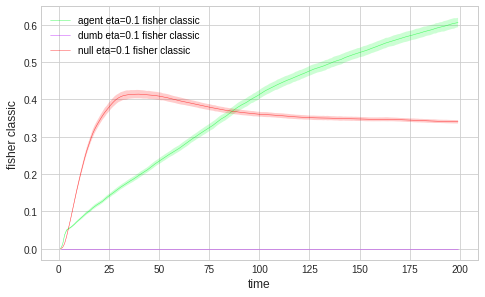

<Figure size 490.162x302.937 with 0 Axes>

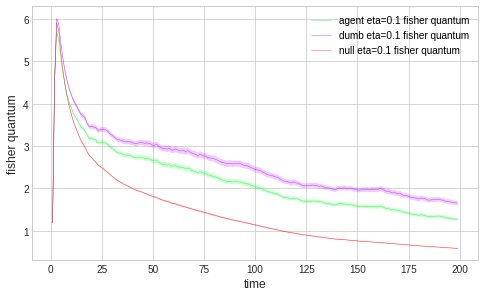

<Figure size 490.162x302.937 with 0 Axes>

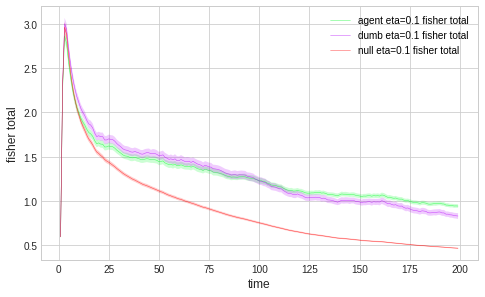

In [7]:
#plot delle fisher classiche, quantistiche, e totali per eta=0.1. In ogni grafico ci sono agente, feedback scemo e nessun feedback 
plt.rcParams['figure.figsize'] = figsize(2) #grandezza figura
x=mean(Data_09_null['t']) #asse del tempo
a=0.7 #trasparenza linee
a2=0.2 #trasparenza intervalli
l=0.5 #spessore linee


plt.figure('fishercl')
fig, ax = plt.subplots()
ax.plot(x,fishercl01agent,linestyle='solid',linewidth=l,label=r'agent eta=0.1 fisher classic',alpha=a)
ax.fill_between(x, fishercl01agent-0.5*fishercl01agent_int, fishercl01agent+0.5*fishercl01agent_int,alpha=a2)
ax.plot(x,fishercl01dumb,linestyle='solid',linewidth=l,label=r'dumb eta=0.1 fisher classic',alpha=a)
ax.fill_between(x, fishercl01dumb-0.5*fishercl01dumb_int, fishercl01dumb+0.5*fishercl01dumb_int,alpha=a2)
ax.plot(x,fishercl01null,linestyle='solid',linewidth=l,label=r'null eta=0.1 fisher classic',alpha=a)
ax.fill_between(x, fishercl01null-0.5*fishercl01null_int, fishercl01null+0.5*fishercl01null_int,alpha=a2)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('fisher classic')
plt.tight_layout()



plt.figure('fisherq')
fig, ax = plt.subplots()
ax.plot(x,fisherq01agent,linestyle='solid',linewidth=l,label=r'agent eta=0.1 fisher quantum',alpha=a)
ax.fill_between(x, fisherq01agent-0.5*fisherq01agent_int, fisherq01agent+0.5*fisherq01agent_int,alpha=a2)
ax.plot(x,fisherq01dumb,linestyle='solid',linewidth=l,label=r'dumb eta=0.1 fisher quantum',alpha=a)
ax.fill_between(x, fisherq01dumb-0.5*fisherq01dumb_int, fisherq01dumb+0.5*fisherq01dumb_int,alpha=a2)
ax.plot(x,fisherq01null,linestyle='solid',linewidth=l,label=r'null eta=0.1 fisher quantum',alpha=a)
ax.fill_between(x, fisherq01null-0.5*fisherq01null_int, fisherq01null+0.5*fisherq01null_int,alpha=a2)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('fisher quantum')
plt.tight_layout()



plt.figure('fishertot')
fig, ax = plt.subplots()
ax.plot(x,fishertot01agent,linestyle='solid',linewidth=l,label=r'agent eta=0.1 fisher total',alpha=a)
ax.fill_between(x, fishertot01agent-0.5*fishertot01agent_int, fishertot01agent+0.5*fishertot01agent_int,alpha=a2)
ax.plot(x,fishertot01dumb,linestyle='solid',linewidth=l,label=r'dumb eta=0.1 fisher total',alpha=a)
ax.fill_between(x, fishertot01dumb-0.5*fishertot01dumb_int, fishertot01dumb+0.5*fishertot01dumb_int,alpha=a2)
ax.plot(x,fishertot01null,linestyle='solid',linewidth=l,label=r'null eta=0.1 fisher total',alpha=a)
ax.fill_between(x, fishertot01null-0.5*fishertot01null_int, fishertot01null+0.5*fishertot01null_int,alpha=a2)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('fisher total')
plt.tight_layout()

<Figure size 490.162x302.937 with 0 Axes>

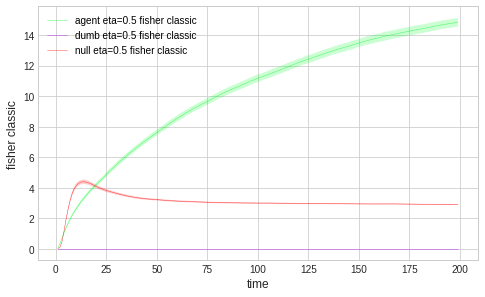

<Figure size 490.162x302.937 with 0 Axes>

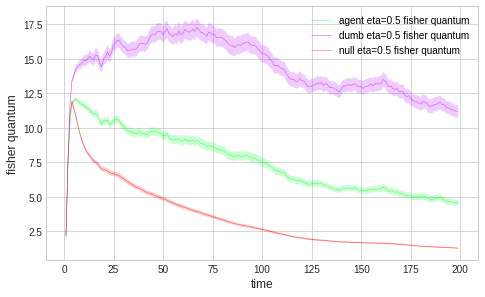

<Figure size 490.162x302.937 with 0 Axes>

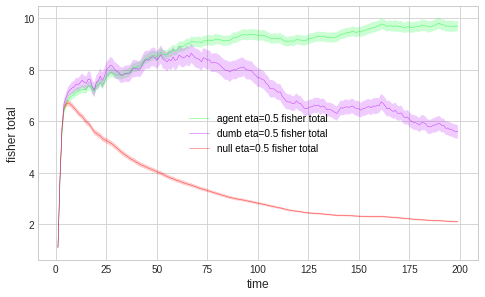

In [8]:
plt.rcParams['figure.figsize'] = figsize(2)
x=mean(Data_09_null['t'])
a=0.7
a2=0.2
l=0.5

plt.figure('fishercl')
fig, ax = plt.subplots()
ax.plot(x,fishercl05agent,linestyle='solid',linewidth=l,label=r'agent eta=0.5 fisher classic',alpha=a)
ax.fill_between(x, fishercl05agent-0.5*fishercl05agent_int, fishercl05agent+0.5*fishercl05agent_int,alpha=a2)
ax.plot(x,fishercl05dumb,linestyle='solid',linewidth=l,label=r'dumb eta=0.5 fisher classic',alpha=a)
ax.fill_between(x, fishercl05dumb-0.5*fishercl05dumb_int, fishercl05dumb+0.5*fishercl05dumb_int,alpha=a2)
ax.plot(x,fishercl05null,linestyle='solid',linewidth=l,label=r'null eta=0.5 fisher classic',alpha=a)
ax.fill_between(x, fishercl05null-0.5*fishercl05null_int, fishercl05null+0.5*fishercl05null_int,alpha=a2)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('fisher classic')
plt.tight_layout()



plt.figure('fisherq')
fig, ax = plt.subplots()
ax.plot(x,fisherq05agent,linestyle='solid',linewidth=l,label=r'agent eta=0.5 fisher quantum',alpha=a)
ax.fill_between(x, fisherq05agent-0.5*fisherq05agent_int, fisherq05agent+0.5*fisherq05agent_int,alpha=a2)
ax.plot(x,fisherq05dumb,linestyle='solid',linewidth=l,label=r'dumb eta=0.5 fisher quantum',alpha=a)
ax.fill_between(x, fisherq05dumb-0.5*fisherq05dumb_int, fisherq05dumb+0.5*fisherq05dumb_int,alpha=a2)
ax.plot(x,fisherq05null,linestyle='solid',linewidth=l,label=r'null eta=0.5 fisher quantum',alpha=a)
ax.fill_between(x, fisherq05null-0.5*fisherq05null_int, fisherq05null+0.5*fisherq05null_int,alpha=a2)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('fisher quantum')
plt.tight_layout()



plt.figure('fishertot')
fig, ax = plt.subplots()
ax.plot(x,fishertot05agent,linestyle='solid',linewidth=l,label=r'agent eta=0.5 fisher total',alpha=a)
ax.fill_between(x, fishertot05agent-0.5*fishertot05agent_int, fishertot05agent+0.5*fishertot05agent_int,alpha=a2)
ax.plot(x,fishertot05dumb,linestyle='solid',linewidth=l,label=r'dumb eta=0.5 fisher total',alpha=a)
ax.fill_between(x, fishertot05dumb-0.5*fishertot05dumb_int, fishertot05dumb+0.5*fishertot05dumb_int,alpha=a2)
ax.plot(x,fishertot05null,linestyle='solid',linewidth=l,label=r'null eta=0.5 fisher total',alpha=a)
ax.fill_between(x, fishertot05null-0.5*fishertot05null_int, fishertot05null+0.5*fishertot05null_int,alpha=a2)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('fisher total')
plt.tight_layout()

<Figure size 490.162x302.937 with 0 Axes>

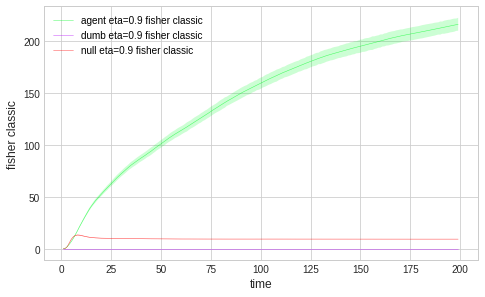

<Figure size 490.162x302.937 with 0 Axes>

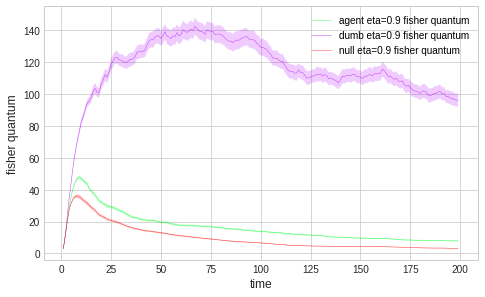

<Figure size 490.162x302.937 with 0 Axes>

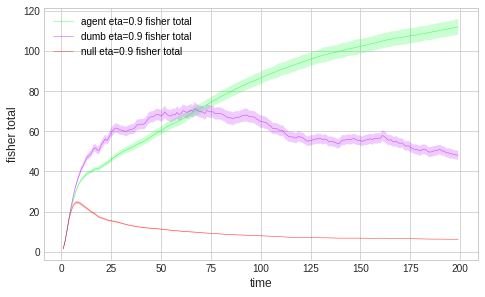

In [10]:
plt.rcParams['figure.figsize'] = figsize(2)
x=mean(Data_09_null['t'])
a=0.7
a2=0.2
l=0.5
plt.figure('fishercl')
fig, ax = plt.subplots()
ax.plot(x,fishercl09agent,linestyle='solid',linewidth=l,label=r'agent eta=0.9 fisher classic',alpha=a)
ax.fill_between(x, fishercl09agent-0.5*fishercl09agent_int, fishercl09agent+0.5*fishercl09agent_int,alpha=a2)
ax.plot(x,fishercl09dumb,linestyle='solid',linewidth=l,label=r'dumb eta=0.9 fisher classic',alpha=a)
ax.fill_between(x, fishercl09dumb-0.5*fishercl09dumb_int, fishercl09dumb+0.5*fishercl09dumb_int,alpha=a2)
ax.plot(x,fishercl09null,linestyle='solid',linewidth=l,label=r'null eta=0.9 fisher classic',alpha=a)
ax.fill_between(x, fishercl09null-0.5*fishercl09null_int, fishercl09null+0.5*fishercl09null_int,alpha=a2)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('fisher classic')
plt.tight_layout()



plt.figure('fisherq')
fig, ax = plt.subplots()
ax.plot(x,fisherq09agent,linestyle='solid',linewidth=l,label=r'agent eta=0.9 fisher quantum',alpha=a)
ax.fill_between(x, fisherq09agent-0.5*fisherq09agent_int, fisherq09agent+0.5*fisherq09agent_int,alpha=a2)
ax.plot(x,fisherq09dumb,linestyle='solid',linewidth=l,label=r'dumb eta=0.9 fisher quantum',alpha=a)
ax.fill_between(x, fisherq09dumb-0.5*fisherq09dumb_int, fisherq09dumb+0.5*fisherq09dumb_int,alpha=a2)
ax.plot(x,fisherq09null,linestyle='solid',linewidth=l,label=r'null eta=0.9 fisher quantum',alpha=a)
ax.fill_between(x, fisherq09null-0.5*fisherq09null_int, fisherq09null+0.5*fisherq09null_int,alpha=a2)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('fisher quantum')
plt.tight_layout()



plt.figure('fishertot')
fig, ax = plt.subplots()
ax.plot(x,fishertot09agent,linestyle='solid',linewidth=l,label=r'agent eta=0.9 fisher total',alpha=a)
ax.fill_between(x, fishertot09agent-0.5*fishertot09agent_int, fishertot09agent+0.5*fishertot09agent_int,alpha=a2)
ax.plot(x,fishertot09dumb,linestyle='solid',linewidth=l,label=r'dumb eta=0.9 fisher total',alpha=a)
ax.fill_between(x, fishertot09dumb-0.5*fishertot09dumb_int, fishertot09dumb+0.5*fishertot09dumb_int,alpha=a2)
ax.plot(x,fishertot09null,linestyle='solid',linewidth=l,label=r'null eta=0.9 fisher total',alpha=a)
ax.fill_between(x, fishertot09null-0.5*fishertot09null_int, fishertot09null+0.5*fishertot09null_int,alpha=a2)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('fisher total')
plt.tight_layout()

In [11]:
#qui si salvano i valori assoluti di r
absr_09_agent=get_absr(Data_09_agent)
absr_09_dumb=get_absr(Data_09_dumb)
absr_09_null=get_absr(Data_09_null)

absr_05_agent=get_absr(Data_05_agent)
absr_05_dumb=get_absr(Data_05_dumb)
absr_05_null=get_absr(Data_05_null)

absr_01_agent=get_absr(Data_01_agent)
absr_01_dumb=get_absr(Data_01_dumb)
absr_01_null=get_absr(Data_01_null)


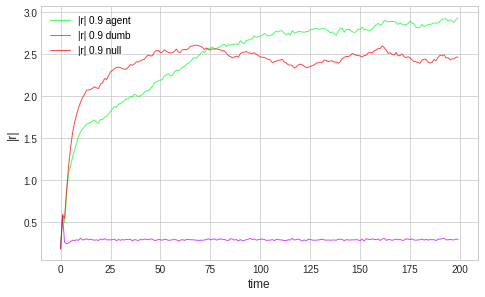

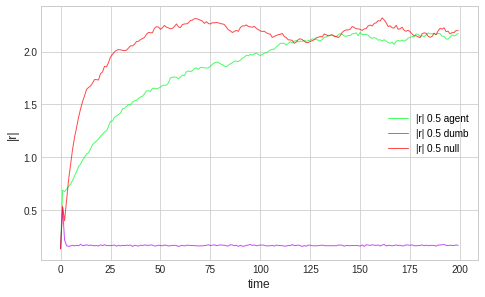

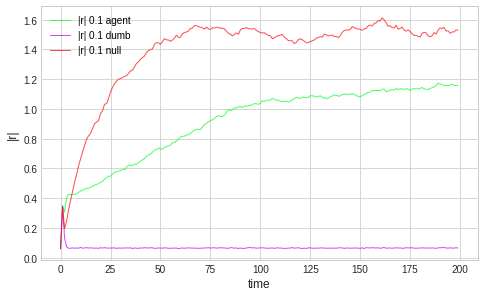

In [12]:
#qui invece si plottano
t=Data_09_agent['t']
plt.rcParams['figure.figsize'] = figsize(2)
l=1
fig, ax = plt.subplots()
ax.plot(t,absr_09_agent,linestyle='solid',linewidth=l,label=r'|r| 0.9 agent',alpha=a)
ax.plot(t,absr_09_dumb,linestyle='solid',linewidth=l,label=r'|r| 0.9 dumb',alpha=a)
ax.plot(t,absr_09_null,linestyle='solid',linewidth=l,label=r'|r| 0.9 null',alpha=a)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('|r|')
plt.tight_layout()

fig, ax = plt.subplots()
ax.plot(t,absr_05_agent,linestyle='solid',linewidth=l,label=r'|r| 0.5 agent',alpha=a)
ax.plot(t,absr_05_dumb,linestyle='solid',linewidth=l,label=r'|r| 0.5 dumb',alpha=a)
ax.plot(t,absr_05_null,linestyle='solid',linewidth=l,label=r'|r| 0.5 null',alpha=a)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('|r|')
plt.tight_layout()

fig, ax = plt.subplots()
ax.plot(t,absr_01_agent,linestyle='solid',linewidth=l,label=r'|r| 0.1 agent',alpha=a)
ax.plot(t,absr_01_dumb,linestyle='solid',linewidth=l,label=r'|r| 0.1 dumb',alpha=a)
ax.plot(t,absr_01_null,linestyle='solid',linewidth=l,label=r'|r| 0.1 null',alpha=a)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('|r|')
plt.tight_layout()

In [15]:
#qui si calcolano le percentuali di traiettorie con squeezing sotto b decibel per agente e nullo per tutti gli eta
b=5 #set squeezing treshold (lower for 0.5 and 0.1)
                    
perc_09_agent=get_perpend_squeeze(Data_09_agent,b)
perc_09_null=get_perpend_squeeze(Data_09_null,b)
perc_05_agent=get_perpend_squeeze(Data_05_agent,b)
perc_05_null=get_perpend_squeeze(Data_05_null,b)
perc_01_agent=get_perpend_squeeze(Data_01_agent,b)
perc_01_null=get_perpend_squeeze(Data_01_null,b)

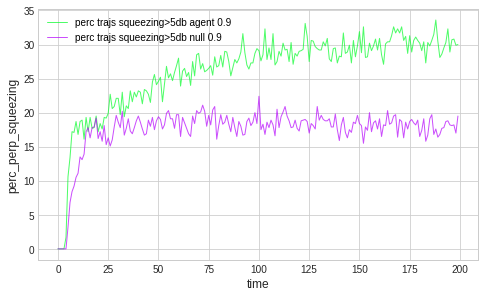

In [16]:
#qui si plottano
fig, ax = plt.subplots()
ax.plot((perc_09_agent*100),linestyle='solid',linewidth=1,label=r'perc trajs squeezing>{}db agent 0.9'.format(b),alpha=a)
ax.plot((perc_09_null*100),linestyle='solid',linewidth=1,label=r'perc trajs squeezing>{}db null 0.9'.format(b),alpha=a)

leg = ax.legend(prop={'size': 10})
text=leg.get_texts()
for i in range(0,len(text)):
    text[i].set_color('black')
plt.xlabel('time')
plt.ylabel('perc_perp_squeezing')
plt.tight_layout()

#fig, ax = plt.subplots()
#ax.plot((perc_05_agent*100),linestyle='solid',linewidth=1,label=r'perc trajs squeezing>{}db agent 0.5'.format(b),alpha=a)
#ax.plot((perc_05_null*100),linestyle='solid',linewidth=1,label=r'perc trajs squeezing>{}db null 0.5'.format(b),alpha=a)

#leg = ax.legend(prop={'size': 10})
#text=leg.get_texts()
#for i in range(0,len(text)):
#    text[i].set_color('black')
#plt.xlabel('time')
#plt.ylabel('perc_perp_squeezing')
#plt.tight_layout()

#fig, ax = plt.subplots()
#ax.plot((perc_01_agent*100),linestyle='solid',linewidth=1,label=r'perc trajs squeezing>{}db agent 0.1'.format(b),alpha=a)
#ax.plot((perc_01_null*100),linestyle='solid',linewidth=1,label=r'perc trajs squeezing>{}db null 0.1'.format(b),alpha=a)

#leg = ax.legend(prop={'size': 10})
#text=leg.get_texts()
#for i in range(0,len(text)):
#    text[i].set_color('black')
#plt.xlabel('time')
#plt.ylabel('perc_perp_squeezing')
#plt.tight_layout()

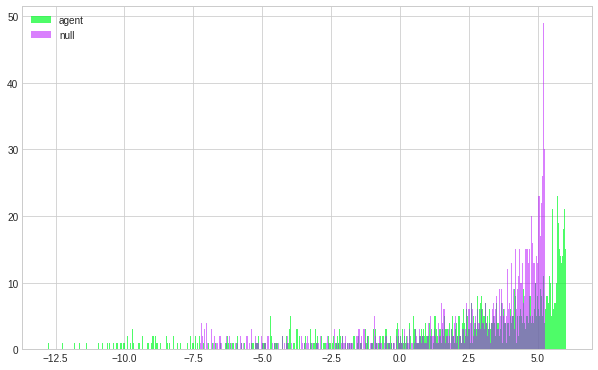

In [17]:
#qui invece si fanno gli istogrammi dei decibel sulle traiettorie per istante fissato i
plt.rcParams['figure.figsize'] = figsize(1.5)

i=199
plt.rcParams['figure.figsize'] = figsize(3)
sc_00=np.array(Data_09_null['sc_00'].to_list())
sc_01=np.array(Data_09_null['sc_01'].to_list())
sc_10=np.array(Data_09_null['sc_10'].to_list())
sc_11=np.array(Data_09_null['sc_11'].to_list())
r_0=np.array(Data_09_null['r_0'].to_list())
r_1=np.array(Data_09_null['r_1'].to_list())

tempo2=[]
min=[]

for j in range(0,1000):

    sc=np.array([[sc_00[i,j],sc_01[i,j]],[sc_10[i,j],sc_11[i,j]]])
    r=np.array([r_0[i,j],r_1[i,j]])
    phi=np.arctan(r[1]/(r[0]))
    R=np.array([[np.cos(-phi),-np.sin(-phi)],[np.sin(-phi),np.cos(-phi)]])
    tmp=R@sc@(R.T)
    tempo2.append(tmp[1,1])

sc_00=np.array(Data_09_agent['sc_00'].to_list())
sc_01=np.array(Data_09_agent['sc_01'].to_list())
sc_10=np.array(Data_09_agent['sc_10'].to_list())
sc_11=np.array(Data_09_agent['sc_11'].to_list())
r_0=np.array(Data_09_agent['r_0'].to_list())
r_1=np.array(Data_09_agent['r_1'].to_list())

tempo=[]

for j in range(0,1000):

    sc=np.array([[sc_00[i,j],sc_01[i,j]],[sc_10[i,j],sc_11[i,j]]])
    r=np.array([r_0[i,j],r_1[i,j]])
    phi=np.arctan(r[1]/(r[0]))
    R=np.array([[np.cos(-phi),-np.sin(-phi)],[np.sin(-phi),np.cos(-phi)]])
    tmp=R@sc@(R.T)
    tempo.append(tmp[1,1])
tempo=-10*np.log10(tempo)
tempo2=-10*np.log10(tempo2)
bins=np.histogram(np.hstack((tempo,tempo2)), bins=500)[1] #get the bin edges
plt.hist(tempo, bins,alpha=0.7,label='agent')
plt.hist(tempo2, bins,alpha=0.5,label='null')
leg = plt.legend(prop={'size': 10})
text=leg.get_texts()
#plt.xlim([3,6.5])
#plt.ylim([0,250])
#plt.tightlayout()

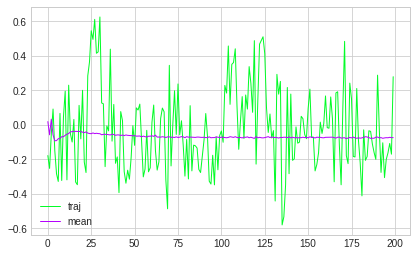

In [45]:
#qui invece si 
plt.rcParams['figure.figsize'] = figsize(2)
traj=np.array(Data_09_agent['action'].to_list())[:,0]
media=np.mean(np.array(Data_09_agent['action'].to_list()),axis=1)
plt.plot(x,traj,linewidth=1,label='traj')
plt.plot(x,media,linewidth=1,label='mean')
leg = plt.legend(prop={'size': 10})
text=leg.get_texts()